In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv("network-data.csv")
df.shape

(4730, 2)

In [55]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape

(395, 2)

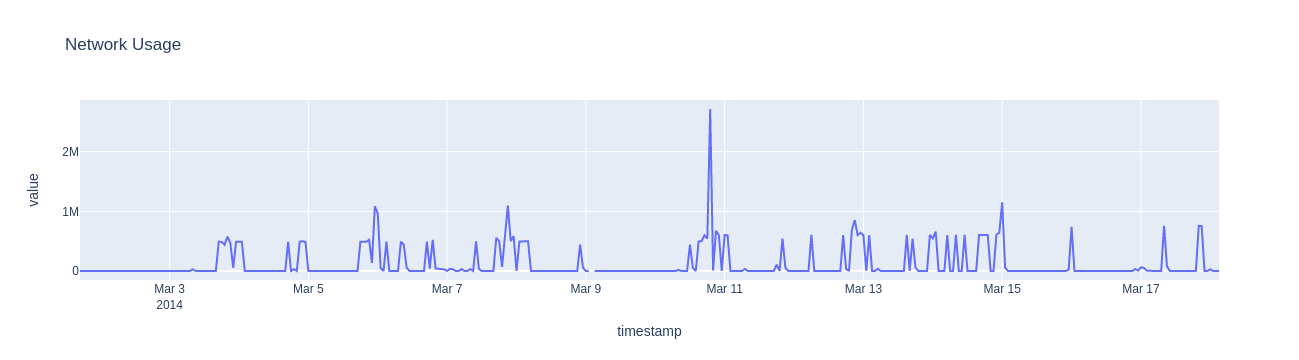

In [75]:
#express to plot entire data
fig = px.line(df.reset_index(), x='timestamp', y='value', title='Network Usage')
#slider
fig.show()


In [62]:
from fbprophet import Prophet
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [66]:
#train test split
train = taxi_df[(taxi_df['ds'] >= '2014-03-01') & (taxi_df['ds'] <= '2014-03-17')]
test = taxi_df[(taxi_df['ds'] > '2014-03-17')]

In [67]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.0258


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         718.1   5.85584e-07       92.4116      0.6543      0.6543      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       718.101   2.96363e-08        84.791      0.5477      0.5477      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [68]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(4)


,ds
483,2014-03-21 20:00:00
484,2014-03-21 21:00:00
485,2014-03-21 22:00:00
486,2014-03-21 23:00:00


In [69]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
482,2014-03-21 19:00:00,380304.904246,80884.025644,692330.362398
483,2014-03-21 20:00:00,366167.508582,68927.981320,658278.963951
484,2014-03-21 21:00:00,376228.296846,76321.647572,656695.571287
485,2014-03-21 22:00:00,411785.675090,120668.488929,701173.221401
486,2014-03-21 23:00:00,437981.058561,122109.494783,736078.397995


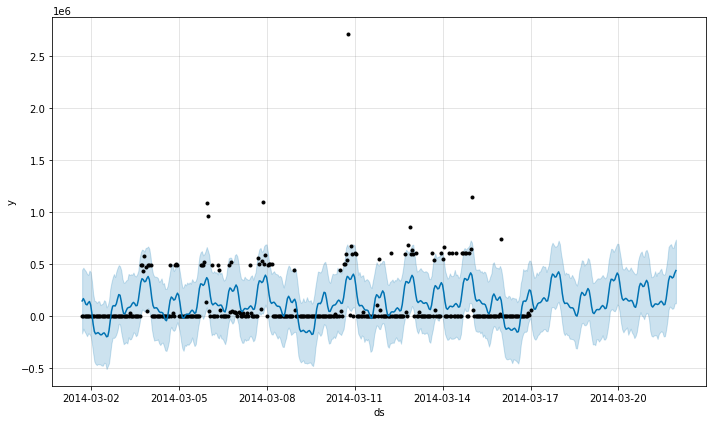

In [70]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

In [71]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [72]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') #Alternate way



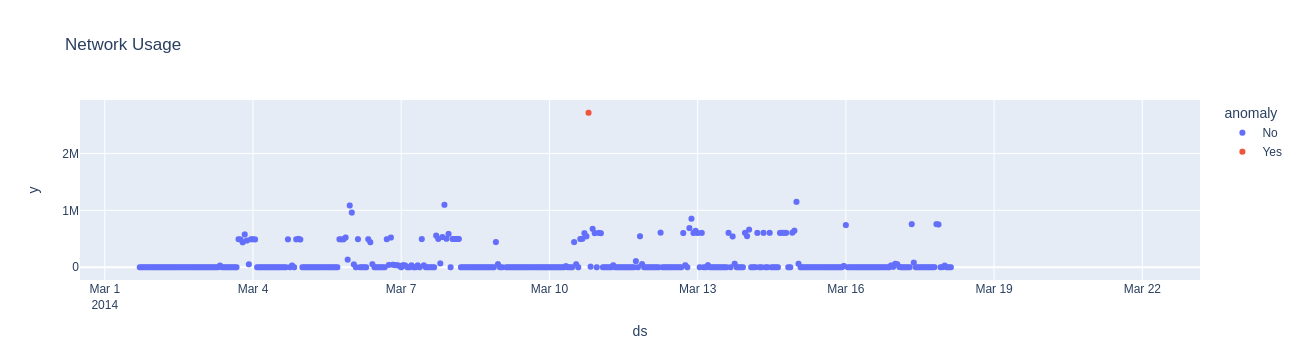

In [77]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Network Usage')
fig.show()